In [25]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [26]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [27]:
# Creating Data
start = 0
end = 1
step = 0.02

x = torch.arange(start, end, step).unsqueeze(dim=1)

In [28]:
weight = 0.7
bias = 0.3

y = (weight * x + bias)

In [29]:
train_ratio = int(0.8 * len(x))
x_train, y_train = x[:train_ratio], y[:train_ratio]
x_test, y_test = x[train_ratio:], y[train_ratio:]

len(x_train), len(x_test)

(40, 10)

In [30]:
def plot_predictions(train_data=x_train,
                     train_labels=y_train,
                     test_data=x_test,
                     test_labels=y_test,
                     predictions=None):

  #Plots training data, test data and compares predictions.

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

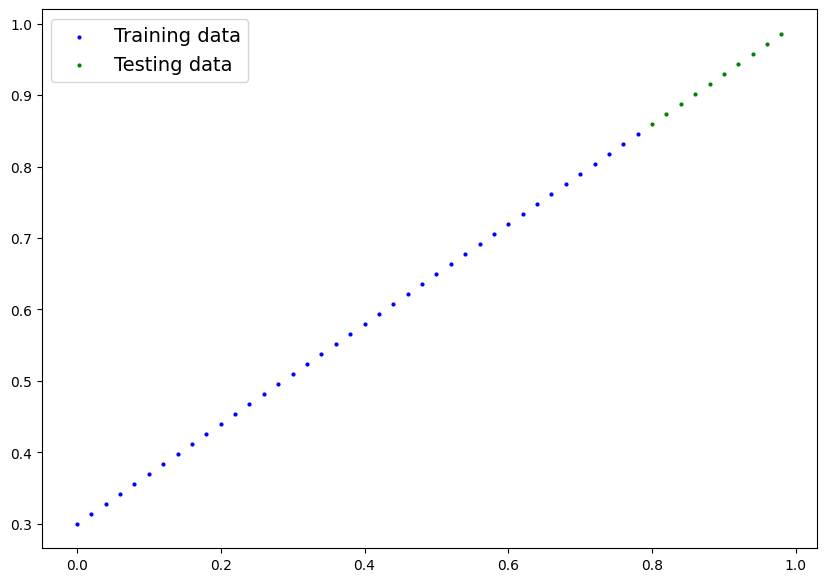

In [31]:
plot_predictions()

In [32]:
class Linear_Regression(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer = nn.Linear(in_features=1,
                              out_features=1)

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.linear_layer(x)

In [33]:
torch.manual_seed(42)
model_1 = Linear_Regression()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [34]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [35]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [40]:
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

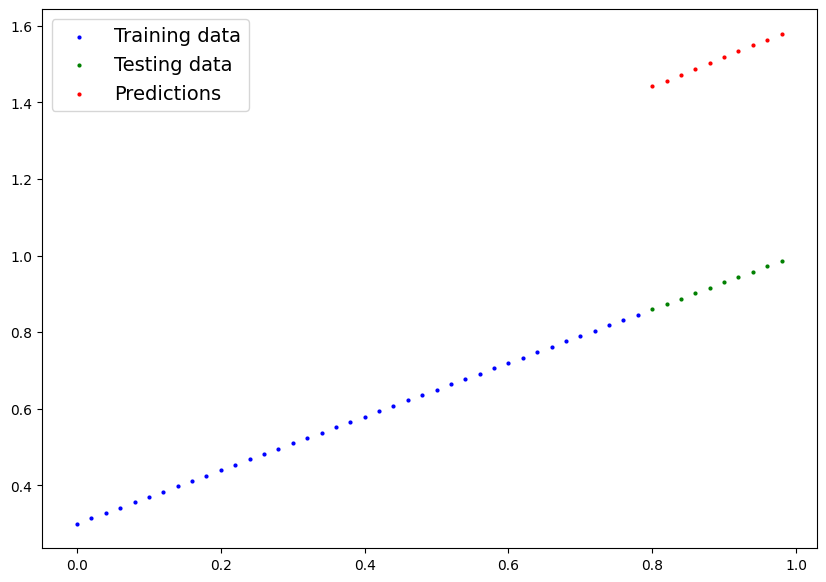

In [45]:
initial_pred = model_1(x_test)
plot_predictions(predictions= initial_pred.cpu().detach().numpy())

In [46]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [47]:
# Setting a loss function
loss_fn = nn.L1Loss()

# Picking an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.001)

In [48]:
epochs = 2000

for epoch in range(epochs):
  # Setting the model on training mode
  model_1.train() #train mode sets all parameters that require grad to require grad

  # 1. Forward Pass
  y_pred = model_1(x_train)

  # 2. Loss Function
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer
  optimizer.zero_grad() # Here we zero the model previous gradience to avoid default accumlation at step 5

  # 4. back_propagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  # printing the loss
  if epoch % 100 == 0:
    print(f"loss: {loss}")
    print(model_1.state_dict())

loss: 0.5551779866218567
OrderedDict([('linear_layer.weight', tensor([[0.7641]], device='cuda:0')), ('linear_layer.bias', tensor([0.8290], device='cuda:0'))])
loss: 0.4399694502353668
OrderedDict([('linear_layer.weight', tensor([[0.7251]], device='cuda:0')), ('linear_layer.bias', tensor([0.7290], device='cuda:0'))])
loss: 0.3247610330581665
OrderedDict([('linear_layer.weight', tensor([[0.6861]], device='cuda:0')), ('linear_layer.bias', tensor([0.6290], device='cuda:0'))])
loss: 0.209552600979805
OrderedDict([('linear_layer.weight', tensor([[0.6472]], device='cuda:0')), ('linear_layer.bias', tensor([0.5290], device='cuda:0'))])
loss: 0.09434414654970169
OrderedDict([('linear_layer.weight', tensor([[0.6082]], device='cuda:0')), ('linear_layer.bias', tensor([0.4290], device='cuda:0'))])
loss: 0.024156799539923668
OrderedDict([('linear_layer.weight', tensor([[0.5873]], device='cuda:0')), ('linear_layer.bias', tensor([0.3558], device='cuda:0'))])
loss: 0.019893135875463486
OrderedDict([('li

In [49]:
# Testing
model_1.eval()
with torch.inference_mode():
  # Forward Pass
  y_test_pred = model_1(x_test)

  # Calculate the loss
  test_loss = loss_fn(y_test_pred, y_test)

In [50]:
weight, bias, test_loss

(0.7, 0.3, tensor(0.0007, device='cuda:0'))

In [51]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6999]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3008], device='cuda:0'))])

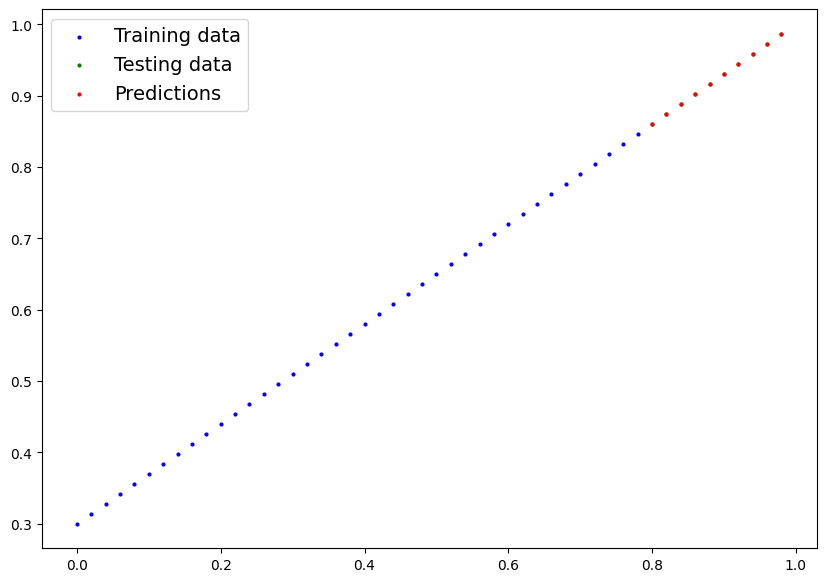

In [53]:
plot_predictions(predictions=y_test_pred.cpu())

In [54]:
# Saving the model
from pathlib import Path

# Creating models path
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)

# Saving the model there
MODEL_NAME = "Linear_Regression_V2.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/Linear_Regression_V2.pth


In [55]:
# Loading the model
# 1. Instantiating a new instanse of the model
loaded_model = Linear_Regression()

# 2. Load the state dict of the model
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [57]:
loaded_model.to(device)

Linear_Regression(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [58]:
loaded_model.eval()
with torch.inference_mode():
  loaded_model_pred = loaded_model(x_test)
loss_fn(loaded_model_pred, y_test)

tensor(0.0007, device='cuda:0')

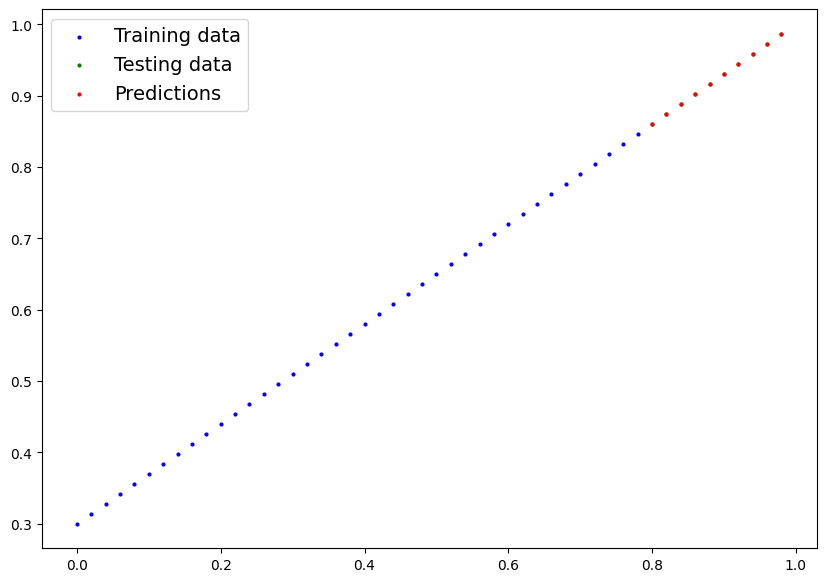

In [60]:
plot_predictions(predictions= loaded_model_pred.cpu().detach().numpy())